This notebook functionizes the 'Array to ASPA'. Goal is to convert any input dictionary to a usable ASPA for analysis.

IMPORTANT:
During the visualisation of the images. Each cmap per individual image is scaled depending on the contents. Therefor the images array has to be saved and used... Saving the PNG's will give faulty results. 

TODO:
Split up all features into e.g. 4 scales so they can be scaled and distuingished better?
But also reserve space for 'cloud' models. 

# Imports

In [11]:
import numpy as np
import seaborn as sns
import pandas as pd


import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from keijzer_exogan import *


%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
sns.set()

# Load chunk

In [12]:
dir = 'F:\\Jupyterlab\\DCGAN\\data\\ExoGAN\\'

X = load_all_to_array(dir)

np.random.seed(23) # Set seed for the np.random functions

# Shuffle X along the first axis to make the order of simulations random
np.random.shuffle(X) # note that X = np.rand.... isn't required

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]c:\program files\python36\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [04:12<00:00, 21.02s/it]


In [13]:
# scale the data
def scale_param(X, X_min, X_max):
    """
    Formule source: 
    https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    
    In this case 1 is max, 0 is min
    """
    std = (X-X_min)/ (X_max - X_min)
    return std*(1 - 0)+0

In [14]:
cmap = 'RgYlGn'

def dict_to_ASPA(x):
    """
    Transforms the input dictionary (in the format of ExoGAN), to the ASPA format.
    TODO:
    
    - devide each parameter in bins and scale the data per bin (to hopefully increase the contrast in the data)
    - make sure to leave space for cloud model information (max2, min2 is currently double info from max1, min1)
    """
    
    spectrum = x['data']['spectrum']

    if len(spectrum) != 515:
        print('Spectrum length != 515. breaking script')
        #break

    """
    Scale the spectrum
    """
    spectrum = spectrum.reshape(-1, 1) # convert 1D array to 2D cause standardscaler requires it

    scaler = MinMaxScaler(feature_range=(0,1)).fit(spectrum)
    std = np.std(spectrum)
    min_ = spectrum.min()
    max_ = spectrum.max()

    spectrum = scaler.transform(spectrum)

    # fill spectrum to have a size of 529, to then reshape to 23x23
    spectrum = np.append(spectrum, [0 for _ in range(14)]) # fill array to size 529 with zeroes
    spectrum = spectrum.reshape(23, 23) # building block one
    
    # Also scale min_ max_ from the spectrum
    min_ = scale_param(min_, 6.5e-3, 2.6e-2)
    max_ = scale_param(max_, 6.5e-3, 2.6e-2)

    """
    Add the different building blocks to each other
    """

    max1 = np.full((12,6), max_) # create array of shape 12,6 (height, width) with the max_ value
    min1 = np.full((11,6), min_)
    max1min1 = np.concatenate((max1, min1), axis=0) # Add min1 below max1 (axis=0) 

    image = np.concatenate((spectrum, max1min1), axis=1) # Add max1min1 to the right of spectrum (axis=1)

    """
    Get all parameters and scale them
    """
    # Get the param values
    ch4 = x['param']['ch4_mixratio']
    co2 = x['param']['co2_mixratio']
    co = x['param']['co_mixratio']
    h2o = x['param']['h2o_mixratio']
    mass = x['param']['planet_mass']
    radius = x['param']['planet_radius']
    temp = x['param']['temperature_profile']

    # Scale params (parm, min_value, max_value) where min/max should be the 
    ch4 = scale_param(ch4, 1e-8, 1e-1)
    co2 = scale_param(co2, 1e-8, 1e-1)
    co = scale_param(co, 1e-8, 1e-1)
    h2o = scale_param(h2o, 1e-8, 1e-1)
    mass = scale_param(mass, 1.5e27, 3.8e27)
    radius = scale_param(radius, 5.6e7, 1.0e8)
    temp = scale_param(temp, 1e3, 2e3)

    # Create the building blocks
    co2 = np.full((23,1), co2)
    co = np.full((23,1), co)
    ch4 = np.full((23,1), ch4)


    mass = np.full((1,23), mass)
    radius = np.full((1,23), radius)
    temp = np.full((1,23), temp)

    h2o = np.full((9,9), h2o)

    max2 = np.full((6,12), max_) # create array of shape 12,7 (height, width) with the max_ value
    min2 = np.full((6,11), min_)

    """
    Put building blocks together
    """
    image = np.concatenate((image, co2), axis=1)
    image = np.concatenate((image, co), axis=1)
    image = np.concatenate((image, ch4), axis=1)

    sub_image = np.concatenate((max2, min2), axis=1)
    sub_image = np.concatenate((sub_image, mass), axis=0)
    sub_image = np.concatenate((sub_image, radius), axis=0)
    sub_image = np.concatenate((sub_image, temp), axis=0)
    sub_image = np.concatenate((sub_image, h2o), axis=1)

    image = np.concatenate((image, sub_image), axis=0)
    
    return image

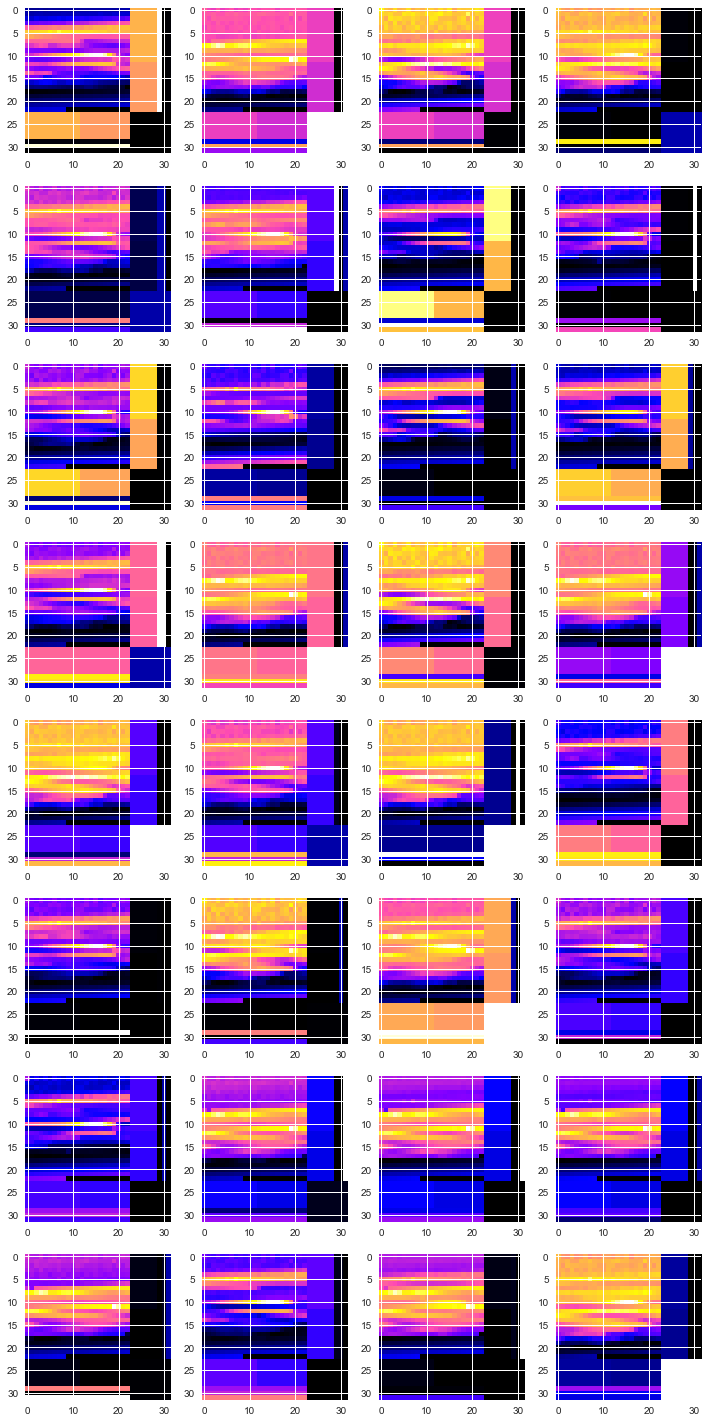

In [15]:
plt.figure(figsize=(10,20))

for i in range(8*4):
    image = dict_to_ASPA(X[i])
    

    plt.subplot(8, 4, i+1)
    plt.imshow(image, cmap='gnuplot2')
    plt.tight_layout()

# Creating images from all simulations in the chunk

In [16]:
images = []
for i in tqdm(range(len(X))):
    image = dict_to_ASPA(X[i])
    image = image.reshape(1, 32, 32) # [images, channel, width, height]
    images.append(image)
    
images = np.array(images)
images.shape

  2%|█▍                                                                      | 23794/1200000 [00:09<08:12, 2386.26it/s]c:\program files\python36\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████████████████████████████████████████████████████████████████| 1200000/1200000 [11:41<00:00, 1711.68it/s]


(1200000, 1, 32, 32)

# Saving this array to disk

In [ ]:
np.save(dir+'chunk_rnd_images.npy', images)

# Test loading and visualization

In [ ]:
images = np.load(dir+'chunk_rnd_images.npy')

In [19]:
np.unique(images)

array([-0.00161818, -0.001441  , -0.00144036, ...,  1.21437357,
        1.21437511,  1.21437617])

TypeError: Invalid dimensions for image data

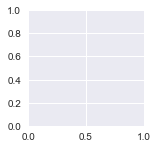

In [20]:
plt.figure(figsize=(10,20))

for i in range(8*4):
    image = images[i]
    

    plt.subplot(8, 4, i+1)
    plt.imshow(image, cmap='gnuplot2')
    plt.tight_layout()